# Workshop WDL

#### In data science, extensive analysis and experimentation are needed before reaching close to a final solution. However, that does not mean we should relax on its code development. So, we propose an exploration with a production mindset, where we enable training code to be used for production as a lightweight framework.

# Training
In this section, we will train a simple model and explore the concepts presented.

## Project Structure

```python
.
├── inference  # Everything thats is needed for model deployment
│   ├── architectures
│   │   └── text_classification
│   │       └── baseline.py
│   └── data_processors
│       ├── processor.py
│       └── transformers
│           ├── base.py
│           └── preprocessing
│               └── vocab_transform.py
├── training # The remaining part that is exclusively needed for training
│   ├── data_augmentation
│   │   └── sentence_augmentation.py
│   ├── datasets
│   │   └── text_classification
│   │       └── ag_news.py
│   └── trainer
│       └── text_classification.py
├── scripts
│   └── train.py  # Script to train model in server
├── setup.cfg  # auxiliary tools setup (flake8, mypy pydocstyle, pytest) 
├── tests
│   └── unit
│       └── inference
│           ├── architecture
│           │   └── text_classification
│           │       └── test_baseline.py
│           └── data_processors
│               └── test_base.py
├── notebooks # Exploration notebooks for data analysis
│   └── Workshop_WDL.ipynb
├── Makefile
├── README.md
├── poetry.lock
├── pyproject.toml
└── requirements.txt
```




### Setup Environment

In [ ]:
!git clone https://github.com/dlite-tools/nlp-training

In [ ]:
%cd nlp-training/

In [ ]:
!git pull

In [ ]:
!pip3 install -r requirements.txt

#### Imports

In [ ]:
import os
import tempfile

import torch
from torchtext.datasets import AG_NEWS
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateMonitor
)

from inference.architectures.text_classification import BaselineModel
from inference.data_processors.transformers import BaseTransformer
from inference.data_processors.processor import Processor
from inference.data_processors.transformers.preprocessing import VocabTransform
from training.trainer import TextClassificationTrainer
from training.datasets.text_classification import AGNewsDataModule
from training.utils import log_vocab

## Hyper-parameters and other Settings


In [ ]:
NUMBER_CLASSES = 4
N_EPOCHS = 20
EMBED_DIM = 64
BATCH_SIZE = 64
NUM_WORKERS = 8

## Data transformation pipeline

### Build a Tokenizer

Implement a class that inherits from `BaseTransformer`.


This class must have implemented the method `__call__` that receives
a string and return a list of strings.

Tokenization consist on breaking a raw text into small parts, could be word, setences or a char n-gram.

e.g.

Given a text: `'This is a random workshop'`

The tokenizer should return: `['This', 'is', 'a', 'random' workshop']`


In [ ]:
from typing import List
from string import punctuation


class Transform(BaseTransformer):
    def __call__(self, text: str) -> List[str]:
        raise NotImplementedError  


class Transform(BaseTransformer):
    def __call__(self, text: str) -> List[str]:
        return text.lower().translate(str.maketrans('', '', punctuation)).split(' ')


### Processor

The processor is a object that will sequentially apply the transformation to the data.

Each transform inherits from `BaseTransformer`, and since is applied sequentially the output of a transform will be an input of the following transform. So, we must take into consideration the order of them, if one just upper or lower cases the string but is given a list of string in might cause a error. However, as future work, could be implemented multiple `BaseTransformer` variations that check if they are in the correct order, similar to what is done on [NLPiper](https://github.com/dlite-tools/NLPiper#compose).


#### Vocab

Here we will also generate the vocabulary. The vocabulary consists on giving a unique number for each unique token that appears on the training set. It also contains a special token for unknown words that might appear on validation or test set.

In [ ]:
vocab = VocabTransform()
preprocessing = [
    Transform(),
    vocab
]
processor = Processor(preprocessing=preprocessing)


vocab.build_vocab(processor, AG_NEWS(split='train'))

print(f"\nVocabulary as size of {len(vocab)}.")

Try to modify the `Transform` to also remove symbols.

tip:
 use `from string import punctuation` to get the punctuation that should be removed

It also could be useful `str.maketrans`:
```python
>>> mapping = str.maketrans('S', 'P')
>>> mapping
{83: 80}
```


And `str.translate`:
```python
>>> txt = 'Hello Sam!'
>>> txt.translate({83: 80})
'Hello Pam!'
```


More info: https://www.w3schools.com/python/ref_string_maketrans.asp

### Setup data module

In [ ]:
data_module = AGNewsDataModule(processor=processor, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)


## Model and Model Trainer

In [ ]:
model_checkpoint = ModelCheckpoint(monitor="valid_loss", mode="min", save_weights_only=True)
early_stop_callback = EarlyStopping(monitor="valid_loss", mode="min", patience=4)
learning_rate_monitor = LearningRateMonitor()
mf_logger = MLFlowLogger(
    experiment_name="AG News - Text Classification",
    run_name="Baseline",
)
log_vocab(vocab, mf_logger)

model = BaselineModel(vocab_size=len(vocab), embed_dim=EMBED_DIM, num_class=NUMBER_CLASSES)

model_trainer = TextClassificationTrainer(
    model=model,
    num_class=NUMBER_CLASSES
)

trainer = Trainer(
    callbacks=[model_checkpoint, early_stop_callback, learning_rate_monitor],
    max_epochs=N_EPOCHS,
    logger=mf_logger,
    gpus=torch.cuda.device_count(),
)

### Training and testing

In [ ]:
trainer.fit(model_trainer, data_module)
trainer.test(datamodule=data_module)

## Lets try to add Data augmentation to our training

For that you can create a new transform based on `Tokenize`.
Since we only want to apply on training set, we should set attribute `_data_aug` to `True`

Tips:

```
>>> import nltk
>>> import nlpaug.augmenter.word as naw
>>> nltk.download('wordnet')
>>> nltk.download('omw-1.4')
>>> nltk.download('averaged_perceptron_tagger')
>>> aug = naw.SynonymAug()
>>> aug.augment('This is our random workshop on World Data League.')
'This is our random workshop on Earthly concern Datum League.'
```

In [ ]:
import nltk
import nlpaug.augmenter.word as naw


class SentenceAugmentation(BaseTransformer):
    _data_aug = True

    def __call__(self, text: str) -> List[str]:
        raise NotImplementedError  


class SentenceAugmentation(BaseTransformer):
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('averaged_perceptron_tagger')
    aug = naw.SynonymAug()
    _data_aug = True

    def __call__(self, text: str) -> str:
        return self.aug.augment(text)

In [ ]:

vocab = VocabTransform()
preprocessing = [
    Transform(),
    SentenceAugmentation(),
    vocab
]

processor = Processor(preprocessing=preprocessing)
vocab.build_vocab(processor, AG_NEWS(split='train'))

print(f"Vocabulary as size of {len(vocab)}.")

In [ ]:
model_checkpoint = ModelCheckpoint(monitor="valid_loss", mode="min", save_weights_only=True)
early_stop_callback = EarlyStopping(monitor="valid_loss", mode="min", patience=4)
learning_rate_monitor = LearningRateMonitor()
mf_logger = MLFlowLogger(
    experiment_name="AG News - Text Classification",
    run_name="Baseline w/Sentence Augmentation",
)
log_vocab(vocab, mf_logger)

data_module = AGNewsDataModule(processor=processor, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)

model = BaselineModel(vocab_size=len(vocab), embed_dim=EMBED_DIM, num_class=NUMBER_CLASSES)

model_trainer = TextClassificationTrainer(
    model=model,
    num_class=NUMBER_CLASSES
)

trainer = Trainer(
    callbacks=[model_checkpoint, early_stop_callback, learning_rate_monitor],
    max_epochs=N_EPOCHS,
    logger=mf_logger,
    gpus=torch.cuda.device_count(),
)

In [ ]:
trainer.fit(model_trainer, data_module)
trainer.test(datamodule=data_module)

## Using NLPiper Integration

In [ ]:
import nlpiper
from inference.data_processors.transformers.preprocessing import NLPiperIntegration

vocab = VocabTransform()
preprocessing = [
    NLPiperIntegration(pipeline=nlpiper.core.Compose([
        nlpiper.transformers.cleaners.CleanPunctuation(),
        nlpiper.transformers.tokenizers.BasicTokenizer(),
        nlpiper.transformers.normalizers.CaseTokens(),
    ])),
    vocab
]

processor = Processor(preprocessing=preprocessing)
vocab.build_vocab(processor, AG_NEWS(split='train'))

print(f"Vocabulary as size of {len(vocab)}.")

In [ ]:
model_checkpoint = ModelCheckpoint(monitor="valid_loss", mode="min", save_weights_only=True)
early_stop_callback = EarlyStopping(monitor="valid_loss", mode="min", patience=4)
learning_rate_monitor = LearningRateMonitor()
mf_logger = MLFlowLogger(
    experiment_name="AG News - Text Classification",
    run_name="Baseline w/NLPiper",
)
log_vocab(vocab, mf_logger)

data_module = AGNewsDataModule(processor=processor, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)


model = BaselineModel(vocab_size=len(vocab), embed_dim=EMBED_DIM, num_class=NUMBER_CLASSES)

model_trainer = TextClassificationTrainer(
    model=model,
    num_class=NUMBER_CLASSES
)

trainer = Trainer(
    callbacks=[model_checkpoint, early_stop_callback, learning_rate_monitor],
    max_epochs=N_EPOCHS,
    logger=mf_logger,
    gpus=torch.cuda.device_count(),
)

In [ ]:
trainer.fit(model_trainer, data_module)
trainer.test(datamodule=data_module)

## Zip MLFlow logs

In [ ]:
!zip -r mlruns.zip mlruns/

In [ ]:
!rm -rf mlruns

# Serving Machine Learning Model

This guide explores how to create a custom machine learning (ML) API to serve the model that we've built in previously.

## High Level Architecture

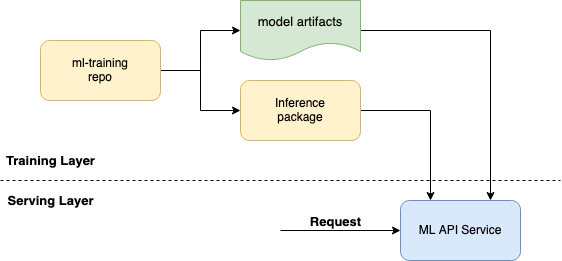

## Project Setup

Let's start by cloning the nlp-api-workshop repository.

```
git clone https://github.com/dlite-tools/nlp-api.git
```

### Install dependencies

We will use [Poetry](https://python-poetry.org/) to manage our dependencies and create a virtual environment for the project.

```
poetry install
```

You can use other tools, like Pipenv, to manage your python virtual environments using the `requirements.txt`.

## Project Structure

```python
.
├── Dockerfile
├── Makefile
├── README.md
├── ml  # machine learning assets
│   ├── model.ckpt
│   └── vocabulary.pth
├── poetry.lock
├── pyproject.toml
├── setup.cfg  # auxiliary tools setup (flake8, mypy pydocstyle, pytest) 
├── src
│   ├── logger.py  # json logger configuration
│   ├── main.py 
│   ├── utils.py  # inference util functions
│   └── version.py 
└── tests
    └── unit
        └── test_main.py
```

## Building a REST API


The core of our API will be:

- [FastAPI](https://fastapi.tiangolo.com/) - lets you easily set up a REST API.
- [Uvicorn](https://www.uvicorn.org/) - server that lets you do async programming with Python.
- [Pydantic](https://pydantic-docs.helpmanual.io/) - data validation by introducing types for our request and response data.

Some tools will help us write some better code:

- [flake8](https://flake8.pycqa.org/en/latest/) - check for code style (PEP 8) compliance
- [mypy](https://mypy.readthedocs.io/en/stable/) - check for type annotations
- [pydocstyle](http://www.pydocstyle.org/en/stable/) - check for docstring style compliance

The code will be written incrementally in the `src/main.py` file that will run the FastAPI app.

### Initializing a FastAPI App Instance

With just one line of code, we can initialize a FastAPI instance as shown below.

```python
from fastapi import FastAPI

app = FastAPI(
    title="NLP API",
    description="Python API for NLP inference"
)
```

This app object is responsible for handling the requests for our REST API for different URIs.

### Defining a Simple GET Request

Now that we have a FastAPI app object, we can use it to define the output for a simple get request as demonstrated below.

```python
from starlette.status import HTTP_200_OK
from src.logger import ENV
from src.version import SERVICE_VERSION

@app.get("/", status_code=HTTP_200_OK)
async def root() -> Dict:
    return {
        "version": SERVICE_VERSION,
        "environment": ENV
    }
```

The get request above for the root URL simply returns a JSON output with a welcome message. We can run the FastAPI app using the following command:

```
make api
```

What will be executed with this command is:

```
uvicorn src.main:app --no-access-log --log-level info --host 0.0.0.0 --port 5000 --reload --reload-dir src
```

The command starts a local Uvicorn server that automatically reloads for any change in the code.

If you go to the localhost URL http://127.0.0.1.5000 in your browser, you should see the JSON message output.

### Automatically Generated Documentation

If you navigate to http://127.0.0.1:5000/docs you will find the documentation page for the FastAPI app. This Swagger UI documentation is generated by FastAPI and we can interact with the API through it.

## Defining the Inference Endpoint

Now that we now the basics of building an API using FastAPI, let's define the endpoint that will perform the inference for a request.

We already have a skelton of this endpoint but it is missing the logic of load the model, apply preprocessing and posprocessing and make the inference for the request.



## Summary

We hope you now understand better how you can organize a training repository for machine learning models following some patterns that will facilitate model deployment. 

We also saw how to build a simple API using FastAPI and a package generated in the training repository to serve the model.